In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os

# 1. ViT 모델 로드 (사전 학습된 모델)
model = models.vit_b_16(pretrained=True)
model.eval()

# 이미지 전처리 함수 (ViT 입력 크기: 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

def extract_vit_features(image_path):
    """ViT를 이용해 이미지 임베딩 벡터 추출"""
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    with torch.no_grad():
        features = model(image)
    return features.flatten().numpy()

# 3. 클러스터링된 데이터 불러오기 (01.csv)
file_path_01 = '01.csv'  # 클러스터링된 이미지 데이터
clustered_images = pd.read_csv(file_path_01)

tn_tour_photo_merged_path = r"E:\AI_HUB\data\concatenated\tn_tour_photo_merged.csv"
tn_tour_photo_merged = pd.read_csv(tn_tour_photo_merged_path)

# 4. 이미지 파일명 정리
clustered_images["PHOTO_FILE_NM"] = clustered_images["Image_Path"].apply(lambda x: x.split("\\")[-1])

# 중복 제거
clustered_images = clustered_images.drop_duplicates(subset=["PHOTO_FILE_NM"])
tn_tour_photo_merged = tn_tour_photo_merged.drop_duplicates(subset=["PHOTO_FILE_NM"])

# 5. 병합 (INNER JOIN)
merged_df = tn_tour_photo_merged.merge(clustered_images, on="PHOTO_FILE_NM", how="inner")

# 6. 선택된 클러스터 내에서만 추천 가능하도록 필터링
selected_clusters = [1, 3, 4, 5, 6, 8, 10, 12, 16, 23, 25]
merged_df = merged_df[merged_df["Cluster_Label"].isin(selected_clusters)]

# 7. 데이터셋 전체 이미지 ViT 임베딩 사전 계산 및 저장
feature_vectors = []
image_paths = merged_df["Image_Path"].tolist()

for img_path in image_paths:
    try:
        features = extract_vit_features(img_path)
        feature_vectors.append(features)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# 8. 임베딩 벡터 저장 (재사용 가능)
np.save("vit_image_features.npy", np.array(feature_vectors))
np.save("vit_image_paths.npy", np.array(image_paths))
print(f"ViT 임베딩 벡터 저장 완료! ({len(image_paths)}개)")


C:\Users\user\anaconda3\envs\my_new_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\my_new_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\user/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:22<00:00, 15.6MB/s] 


ViT 임베딩 벡터 저장 완료! (285개)


In [2]:
# 9. 저장된 ViT 임베딩 벡터 불러오기
all_features = np.load("vit_image_features.npy")
all_image_paths = np.load("vit_image_paths.npy")

# 10. 사용자가 선택한 이미지 입력
selected_image_path = r"E:\\AI_HUB\\data\\Validation\\raw_data\\VS_photo\\h00019801003p0001.jpg"

# 11. 선택한 이미지의 ViT 벡터 추출
selected_features = extract_vit_features(selected_image_path).reshape(1, -1)

# 12. 선택한 이미지의 클러스터 찾기
selected_cluster = merged_df.loc[merged_df["Image_Path"] == selected_image_path, "Cluster_Label"].values

if len(selected_cluster) > 0:
    selected_cluster = selected_cluster[0]

    # 같은 클러스터 내 이미지 목록 필터링
    cluster_images = merged_df[merged_df["Cluster_Label"] == selected_cluster]["Image_Path"].tolist()
    cluster_image_indices = [i for i, path in enumerate(all_image_paths) if path in cluster_images]

    # 클러스터 내에서만 유사도 계산
    cluster_features = all_features[cluster_image_indices]
    similarities = cosine_similarity(selected_features, cluster_features)
    sorted_indices = np.argsort(similarities[0])[::-1]

    # 13. 상위 5개 추천
    recommended_images = [cluster_images[i] for i in sorted_indices[:5]]
    print(f"클러스터 {selected_cluster} 내 추천 이미지:", recommended_images)
else:
    print("선택한 이미지의 클러스터를 찾을 수 없습니다.")


선택한 이미지의 클러스터를 찾을 수 없습니다.


In [3]:
# 10. 저장된 ViT 임베딩 벡터 불러오기
all_features = np.load("vit_image_features.npy")
all_image_paths = np.load("vit_image_paths.npy")

# 11. 랜덤 선택된 이미지의 ViT 벡터 추출
selected_features = extract_vit_features(random_image).reshape(1, -1)

# 12. 선택한 이미지의 클러스터 찾기
selected_cluster = random_cluster

# 13. 같은 클러스터 내 이미지 목록 필터링
cluster_images = merged_df[merged_df["Cluster_Label"] == selected_cluster]["Image_Path"].tolist()
cluster_image_indices = [i for i, path in enumerate(all_image_paths) if path in cluster_images]

# 14. 클러스터 내에서만 유사도 계산
cluster_features = all_features[cluster_image_indices]
similarities = cosine_similarity(selected_features, cluster_features)
sorted_indices = np.argsort(similarities[0])[::-1]

# 15. 상위 5개 추천
recommended_images = [cluster_images[i] for i in sorted_indices[:5]]
print(f"클러스터 {selected_cluster} 내 추천 이미지:", recommended_images)

NameError: name 'random_image' is not defined

In [5]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os
import random

In [6]:
# ✅ 6. 선택된 클러스터 내에서만 추천 가능하도록 필터링
selected_clusters = [1, 3, 4, 5, 6, 8, 10, 12, 16, 23, 25]
merged_df = merged_df[merged_df["Cluster_Label"].isin(selected_clusters)]



선택된 랜덤 클러스터: 8
선택된 랜덤 이미지: E:\AI_HUB\data\Validation\raw_data\VS_photo\h00580902005p0001.jpg


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ✅ 1. 한글 폰트 설정 (Windows의 경우 "Malgun Gothic", Mac의 경우 "AppleGothic")
plt.rc('font', family='Malgun Gothic')

# ✅ 2. 마이너스 기호가 깨지는 문제 방지
plt.rcParams['axes.unicode_minus'] = False


선택된 랜덤 클러스터: 5
선택된 랜덤 이미지: E:\AI_HUB\data\Validation\raw_data\VS_photo\h00351201008p0016.jpg
클러스터 5 내 추천된 이미지:
E:\AI_HUB\data\Validation\raw_data\VS_photo\h00351201008p0016.jpg
E:\AI_HUB\data\Validation\raw_data\VS_photo\h00214902005p0002.jpg
E:\AI_HUB\data\Validation\raw_data\VS_photo\h00072602002p0006.jpg
E:\AI_HUB\data\Validation\raw_data\VS_photo\h00437204002p0004.jpg
E:\AI_HUB\data\Validation\raw_data\VS_photo\g00270601008p0006.jpg


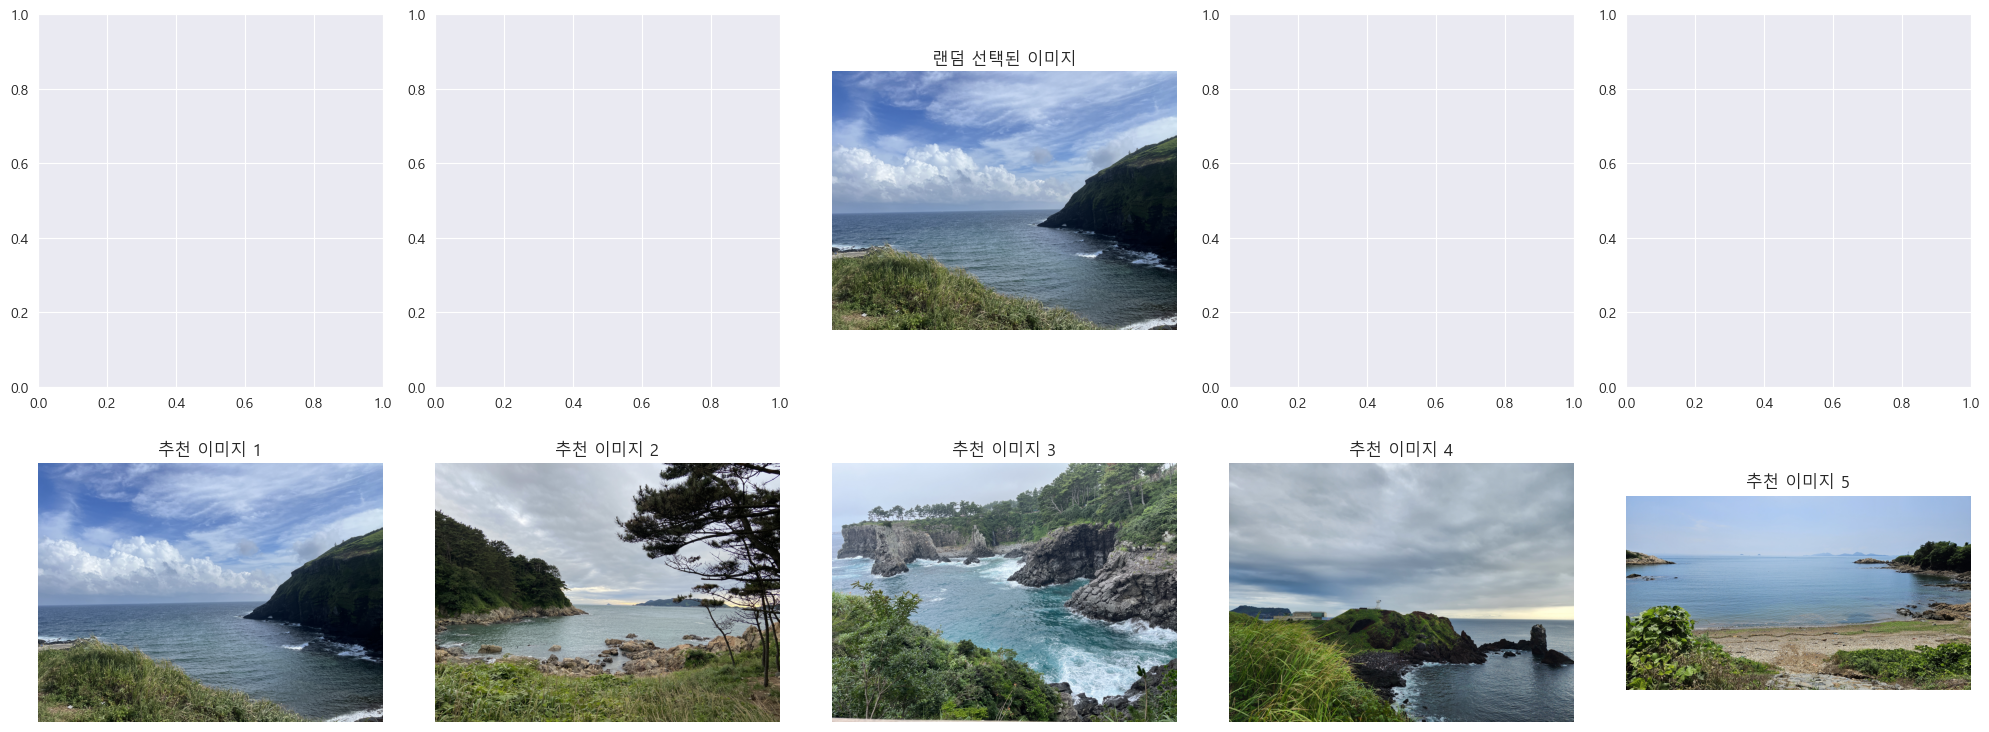

In [14]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 랜덤 클러스터 및 랜덤 이미지 선택
random_cluster = random.choice(selected_clusters)  # 무작위 클러스터 선택
random_image = merged_df[merged_df["Cluster_Label"] == random_cluster].sample(n=1, random_state=42)["Image_Path"].values[0]

print(f"선택된 랜덤 클러스터: {random_cluster}")
print(f"선택된 랜덤 이미지: {random_image}")

# 랜덤 선택된 이미지의 ViT 벡터 추출
selected_features = extract_vit_features(random_image).reshape(1, -1)

# 9. 같은 클러스터 내 이미지 목록 필터링
cluster_images = merged_df[merged_df["Cluster_Label"] == random_cluster]["Image_Path"].tolist()
cluster_image_indices = [i for i, path in enumerate(all_image_paths) if path in cluster_images]

# 같은 클러스터 내에서 유사도 계산
cluster_features = all_features[cluster_image_indices]
similarities = cosine_similarity(selected_features, cluster_features)
sorted_indices = np.argsort(similarities[0])[::-1]

# 11. 상위 5개 추천 이미지 선택
recommended_images = [cluster_images[i] for i in sorted_indices[:5]]

print(f"클러스터 {random_cluster} 내 추천된 이미지:")
for img in recommended_images:
    print(img)

# 12. 선택된 이미지 및 추천된 이미지 시각화
def visualize_selected_and_recommended(selected_image, recommended_images):
    num_recommended = len(recommended_images)

    # 이미지 개수에 맞춰 subplot 생성 (1줄: 선택된 이미지, 2줄: 추천된 이미지)
    fig, axes = plt.subplots(2, num_recommended, figsize=(num_recommended * 4, 8))

    # 선택된 랜덤 이미지 표시
    selected_img = mpimg.imread(selected_image)
    axes[0, num_recommended // 2].imshow(selected_img)
    axes[0, num_recommended // 2].axis("off")
    axes[0, num_recommended // 2].set_title("랜덤 선택된 이미지")

    # 추천된 이미지 표시
    for i, recommended_image in enumerate(recommended_images):
        recommended_img = mpimg.imread(recommended_image)
        axes[1, i].imshow(recommended_img)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"추천 이미지 {i+1}")

    plt.tight_layout()
    plt.show()

# 13. 시각화 실행
visualize_selected_and_recommended(random_image, recommended_images)
